<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Autoencoder%20for%20optic%20discs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset


In [ ]:
from IPython.display import clear_output
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ERn7rS35L3hAg6MH6ktwR4wBJImUoXbLnGS_AHzjFYP65g?download=1"
!sudo chmod 777 "ERn7rS35L3hAg6MH6ktwR4wBJImUoXbLnGS_AHzjFYP65g?download=1"
!mv "ERn7rS35L3hAg6MH6ktwR4wBJImUoXbLnGS_AHzjFYP65g?download=1" "Light_Images.zip"
!unzip Light_Images.zip
!rm Light_Images.zip
!rm OPTOS_Light_Images.csv
clear_output(wait=False)

!wget "https://correoipn-my.sharepoint.com/:x:/g/personal/ccarrillog1400_alumno_ipn_mx/ETQVuYc90PpGktGtEF867g4BCo_28KZdv76nwJ-I_XF4QA?download=1"
!sudo chmod 777 "ETQVuYc90PpGktGtEF867g4BCo_28KZdv76nwJ-I_XF4QA?download=1"
!mv "ETQVuYc90PpGktGtEF867g4BCo_28KZdv76nwJ-I_XF4QA?download=1" "OPTOS_Light_Images.csv"
clear_output(wait=False)

print("Data downloaded")

Data downloaded


In [ ]:
!git clone "https://github.com/Vengadore/GAN_OPTOS.git"

Cloning into 'GAN_OPTOS'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


## Useful imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Load data

In [ ]:
## Path to data
path = "./"
## Load annotations
data = pd.read_csv(os.path.join(path,"OPTOS_Light_Images.csv"))
data.head()

,imageFilename,x,y,x_width,y_width,Class
0,0000.jpeg,2187.0,1395.0,209.0,178.0,Bad
1,0001.jpeg,1438.0,1643.0,136.0,145.0,Bad
2,0002.jpeg,1865.0,2372.0,185.0,190.0,Bad
3,0003.jpeg,2272.0,1484.0,177.0,169.0,Bad
4,0004.jpeg,1726.0,1211.0,185.0,194.0,Bad


In [ ]:
## Drop images with not optic disc
data = data.dropna()
## Add path to filename
data['imageFilename'] = data['imageFilename'].apply(lambda x: os.path.join(path,os.path.join('Light_Images',x)))
## Keep only good images
data['Class'] = data['Class'].apply(lambda x: int(x == "Good"))
data = data[data['Class']==1]
## Get a sample of 600 samples
data = data.sample(600,random_state = 42)
data.head()

,imageFilename,x,y,x_width,y_width,Class
424,./Light_Images/0424.jpeg,1468.0,1546.0,139.0,134.0,1
648,./Light_Images/0648.jpeg,1737.0,2055.0,131.0,143.0,1
788,./Light_Images/0788.jpeg,1724.0,2701.0,165.0,103.0,1
656,./Light_Images/0656.jpeg,1293.0,2398.0,153.0,166.0,1
410,./Light_Images/0410.jpeg,1317.0,1459.0,164.0,145.0,1


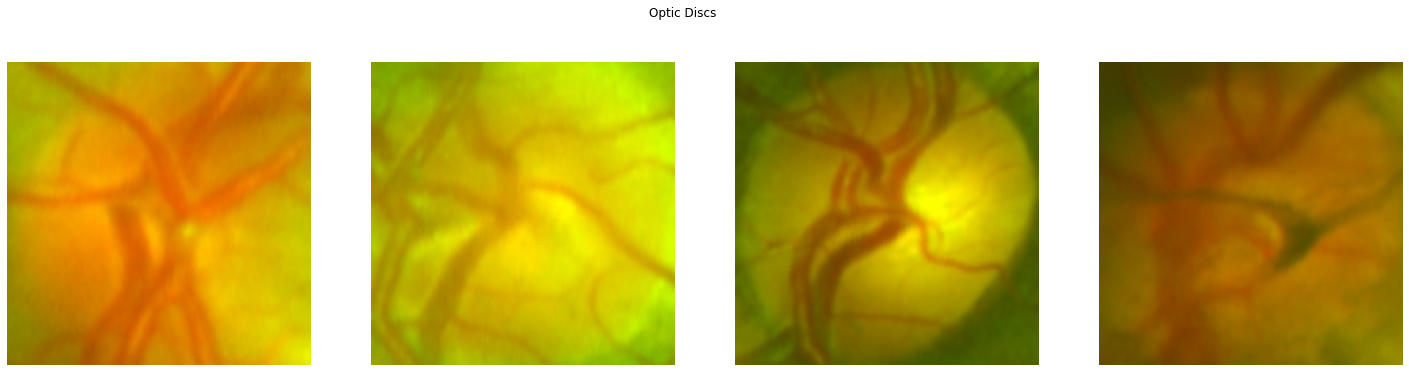

In [ ]:
# Load 4 images
I = [cv2.resize(cv2.cvtColor(cv2.imread(Row[1][0]),4)[int(Row[1][1]):int(Row[1][1]+Row[1][3]),int(Row[1][2]):int(Row[1][2]+Row[1][4])],(224,224)) for Row in data.sample(4,random_state = 0).iterrows()]
I = np.array(I)
# Create array for images and plot them
fig, axs = plt.subplots(1, 4,figsize = (25,6))
fig.suptitle('Optic Discs')
for j in range(4):
    axs[j].imshow(I[j])
    axs[j].axis('off')

## Set parameters for network and data

In [ ]:
# Image size
Image_size = (512,512)
Batch_size = 2
epochs = 20

## Load data into memory

In [ ]:
from GAN_OPTOS.Tools.Visualization.print_data import Progress_bar

In [ ]:
# Read images, crop optic disc, transform from BRG to RGB, and resize images
I = []
Bar = Progress_bar(len(data),60)
for Row in data.iterrows():
    tmp = cv2.resize(cv2.cvtColor(cv2.imread(Row[1][0]),4)[int(Row[1][1]):int(Row[1][1]+Row[1][3]),int(Row[1][2]):int(Row[1][2]+Row[1][4])],Image_size)
    tmp = tmp[:,:,0:-1]
    I.append(tmp)
    Bar.update_progress()
I = np.array(I)
I.shape

Progress: [############################################################] 100.0%


(600, 512, 512, 2)

In [ ]:
## Normalize image to fit from -1 to 1
Normalize = lambda x : cv2.normalize(x, None, alpha=-1,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
## Apply to data
I = map(Normalize,I)
I = np.array(list(I))
I.shape

(600, 512, 512, 2)

## Network definition

In [ ]:
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,MaxPool2D,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LeakyReLU

In [ ]:
## Encoder / Discriminator use LeakyRelu
encoder = Sequential()
encoder.add(Conv2D(256,[3,3],strides = (1,1),activation=LeakyReLU(),input_shape = (Image_size[0],Image_size[1],2)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(128,[3,3],strides = (1,1),activation=LeakyReLU()))
encoder.add(BatchNormalization())
encoder.add(Conv2D(64,[3,3],strides = (1,1),activation=LeakyReLU()))
encoder.add(BatchNormalization())
encoder.add(MaxPool2D(pool_size=(2,2)))

encoder.compile(optimizer = 'adam',loss = 'binary_crossentropy')
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 256)     4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 510, 510, 256)     1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 508, 128)     295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 508, 508, 128)     512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 506, 506, 64)      73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 506, 506, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 253, 253, 64)      0

In [ ]:
## Decoder / Generator use RELU for layers and tanh for final activation function
decoder = Sequential()
decoder.add(Conv2DTranspose(64,[3,3],strides = (1,1),activation = 'relu',input_shape = (109,109,64)))
decoder.add(Conv2DTranspose(64,[3,3],strides = (2,2),activation = 'relu',padding = 'same'))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(128,[3,3],strides = (1,1),activation = 'relu',padding = 'same'))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(256,[3,3],strides = (1,1),activation = 'relu'))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(2,[1,1],strides = (1,1),activation = 'tanh'))

decoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_5 (Conv2DTr (None, 111, 111, 64)      36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 222, 222, 64)      36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 222, 222, 64)      256       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 222, 222, 128)     73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 222, 222, 128)     512       
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 224, 224, 256)     295168    
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 256)    

In [ ]:
Network = Sequential([encoder,decoder])
Network.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])
Network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 253, 253, 64)      375488    
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 2)       445186    
Total params: 820,674
Trainable params: 818,882
Non-trainable params: 1,792
_________________________________________________________________


In [ ]:
## Train network

history = Network.fit(x = I,y = I, batch_size = Batch_size,validation_split= 0.1,epochs= epochs)


Epoch 1/20
175/270 [==================>...........] - ETA: 1:12 - loss: -3.6315 - accuracy: 0.7175

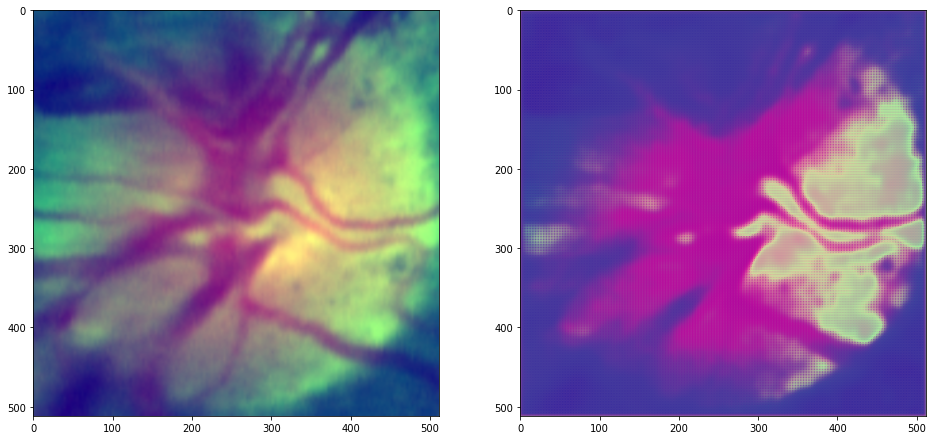

In [ ]:
n = 26
R = Network.predict(np.expand_dims(I[n],axis = 0))
R = R[0]
## Append empty blue channel
Blue = np.expand_dims(np.zeros(Image_size),axis=2)
R = np.append(R,Blue,axis=2)
Test = np.append(I[n],Blue,axis=2)

Normalize2 = lambda x : cv2.normalize(x, None, alpha=0,beta=1,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
fig,axs = plt.subplots(1,2,figsize = (16,8))
axs[1].imshow(Normalize2(R))
axs[0].imshow(Normalize2(Test))

In [ ]:
R.shape

(512, 512, 4)

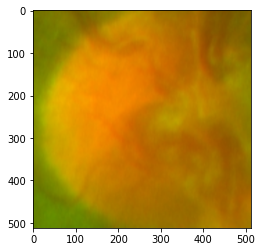

In [ ]:
plt.imshow(Normalize2(I[25]))